In [1]:
import warnings; warnings.simplefilter('ignore')
import os
import matplotlib.pyplot as plt
import wand.image

import io
from skimage.io import imread
import numpy as np
from tqdm import tqdm
from skimage.color import rgb2gray, rgba2rgb
from skimage.transform import resize

%matplotlib inline

In [2]:
files = [f for f in os.listdir('../images') if f.endswith('svg')]

### Get rasterized images from the svg files

In [444]:
def load(filename, width=128, height=128):
    #https://stackoverflow.com/questions/6589358/convert-svg-to-png-in-python
    with open(filename,'rb') as f:
        with wand.image.Image(blob=f.read(), format="svg") as image:
            if width and height:
                image.resize(height=height, width=width)
                
            png_image = image.make_blob("png")

            with io.BytesIO() as blob:
                blob.write(png_image)
                img = imread(blob)
    return rgba2rgb(img)


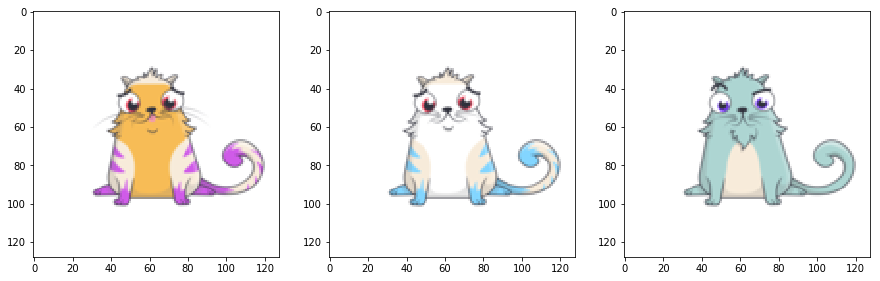

In [445]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
for i in range(3):
    f = np.random.choice(files)
    filename = os.path.join('../images',f)
    img = load(filename)
    ax[i].imshow(img);

In [448]:
#build dataset
fs = np.random.choice(files, 10000)
image_db = np.array( [load(os.path.join('../images',f),width=128, height=128) for f in tqdm(fs)])
np.savez_compressed('cat_sample_128',image_db)

100%|██████████| 10000/10000 [1:04:47<00:00,  2.57it/s]


In [46]:
image_db = np.load('cat_sample.npz')['arr_0']

In [449]:
image_db.shape

(10000, 128, 128, 3)

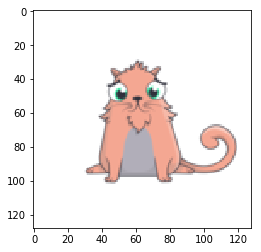

In [450]:
plt.imshow(image_db[0])

In [629]:
import keras.backend as K
from keras import Model
from keras.layers import Add, LeakyReLU, UpSampling2D, Flatten, AveragePooling2D, Reshape, Input, Dense, Conv2D, Conv2DTranspose, concatenate, Lambda, Dropout, MaxPooling2D, Concatenate, BatchNormalization, SeparableConv2D, Activation
from keras.optimizers import Adam
from keras.regularizers import l2

### Generator

Take some random noise vector and output an image

In [ ]:
import tensorflow as tf

In [682]:
tf.reset_default_graph()

In [683]:
K.clear_session()

In [943]:
def generator():
    _input = Input((100,), dtype = np.float32)
    
    X = Dense(1024,activation=None,kernel_initializer='he_normal')(_input)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    
    X = Reshape((8,8,-1))(X) #8*8 * 16
    
    X = Conv2DTranspose(32, (4, 4), strides=(2, 2),kernel_initializer='he_normal', padding='same') (X)
    X = Conv2D(32, (3, 3),kernel_initializer='he_normal',padding='same') (X)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    
    X = Conv2DTranspose(64, (4, 4), strides=(2, 2),kernel_initializer='he_normal', padding='same') (X)
    X = Conv2D(64, (3, 3),kernel_initializer='he_normal',padding='same') (X)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    
    X = Conv2DTranspose(128, (4,4), strides=(2, 2),kernel_initializer='he_normal', padding='same') (X)
    X = Conv2D(128, (3, 3),kernel_initializer='he_normal',padding='same') (X)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    
    X = Conv2DTranspose(256, (4, 4), strides=(2, 2),kernel_initializer='he_normal', padding='same') (X)
    X = Conv2D(256, (3, 3),kernel_initializer='he_normal',padding='same') (X)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    
    X = Conv2D(256, (3, 3),kernel_initializer='he_normal',padding='same') (X)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    
    X = Dropout(.5)(X)
    
    X = Conv2D(3, (1, 1), kernel_initializer='he_normal', padding='same') (X)
    X = BatchNormalization()(X)
    X = Activation('tanh')(X)
    #X = Lambda(lambda x: .5*(x+1))(X) #bring the output of tanh closer to our expected result (0-1)
    
    model = Model(inputs = [_input], outputs=[X])
    return model
    
gen = generator()
gen.compile('adam', loss='mean_squared_error')
gen.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_107 (InputLayer)       (None, 100)               0         
_________________________________________________________________
dense_108 (Dense)            (None, 1024)              103424    
_________________________________________________________________
batch_normalization_445 (Bat (None, 1024)              4096      
_________________________________________________________________
leaky_re_lu_405 (LeakyReLU)  (None, 1024)              0         
_________________________________________________________________
reshape_42 (Reshape)         (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_transpose_114 (Conv2D (None, 16, 16, 32)        8224      
_________________________________________________________________
conv2d_340 (Conv2D)          (None, 16, 16, 32)        9248      
__________

In [944]:
def discriminator():
    _input = Input( (128,128,3), dtype = np.float32)
    
    X = Conv2D(16, (3, 3),kernel_initializer='he_normal', padding='same') (_input)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    X = AveragePooling2D((2,2))(X) #16,16

    X = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same') (X)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    X = AveragePooling2D((2,2))(X) #8,8
    
    X = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same') (X)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    X = AveragePooling2D((2,2))(X) #8,8
    
    X = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same') (X)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    X = AveragePooling2D((2,2))(X) #8,8
    
    X = Flatten()(X)
    X = Dropout(.5)(X)
    
    X = Dense(256,kernel_initializer='he_normal',)(X)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    
    #X = Dropout(.5)(X)
    X = Dense(1, activation='sigmoid')(X)
    
    model = Model(inputs=[_input], outputs=[X])
    return model

disc = discriminator()
opt = Adam(1e-5)
disc.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])
disc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_108 (InputLayer)       (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_346 (Conv2D)          (None, 128, 128, 16)      448       
_________________________________________________________________
batch_normalization_452 (Bat (None, 128, 128, 16)      64        
_________________________________________________________________
leaky_re_lu_411 (LeakyReLU)  (None, 128, 128, 16)      0         
_________________________________________________________________
average_pooling2d_134 (Avera (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_347 (Conv2D)          (None, 64, 64, 32)        4640      
_________________________________________________________________
batch_normalization_453 (Bat (None, 64, 64, 32)        128       
__________

In [901]:
def combined_network(gen, disc):
    
    _input = Input( (100,), dtype=np.float32)
    
    disc.trainable = False
    
    X = gen(_input)
    X = disc(X)
    
    model = Model(inputs = [_input], outputs=[X])
    return model
    
comb = combined_network(gen, disc)
comb.compile('adam', loss='binary_crossentropy')

In [902]:
def pretrain_generator_batch(batch_size=32):
    while True:
        idx = np.random.choice(len(image_db),size=batch_size)
        Y = 2*image_db[idx] -1
        X = np.array([ np.random.choice([1,-1])*resize( x[16:-16,16:-16,:].mean(axis=-1), (10,10)).reshape(100,) for x in Y])
        yield X,Y

In [903]:
def disc_batch(gen, batch_size = 32, true_images= image_db, mode='random'):
    
    if mode=='random':
        n = batch_size

        v = np.random.multivariate_normal(np.zeros(100),np.eye(100),n)
        fake_images = gen.predict(v)

        idx = np.random.choice(len(image_db),size=n)
        real_images = 2*(image_db[idx]-.5) #remap to -1 to 1
        #print(real_images.max())
        X = np.concatenate([fake_images,real_images])
        Y = np.concatenate([np.zeros(n), np.ones(n)])

        #shuffle
        idx = np.random.permutation(len(Y))

        X,Y =  X[idx],Y[idx]
    elif mode=='positive':
        v =  np.random.normal(0,1,(batch_size,100))
        X = gen.predict(v)
        Y = np.zeros(batch_size)
    elif mode =='negative':
        idx = np.random.choice(len(image_db),size=batch_size)
        real_images = 2*( image_db[idx] -.5)
        X = real_images
        Y = np.ones(batch_size)
        
    return X,Y
        
def generate_disc_batch(gen, batch_size = 32, true_images= image_db,mode='random'):
    while True:
        X,Y =  disc_batch(gen, batch_size, true_images, mode)
        yield X,Y
        
def gen_batch(batch_size=32):
    X = np.random.normal(0,1,(batch_size,100))
    Y = np.ones(batch_size)
    return X,Y

def generate_gen_batch(batch_size=32):
    while True:
        yield gen_batch(batch_size)

In [904]:
def group_cats(data,N=4, M=4):
    z = np.zeros((N*128,M*128,3))
    k=0
    for i in range(N):
        for j in range(M):
            z[i*128:(i+1)*128, j*128:(j+1)*128,:] = data[k]
            k+=1
    return np.clip(.5*z+.5,0,1)

In [905]:
from skimage.io import imsave

In [945]:
gen = generator()
gen.compile('adam', loss='mean_squared_error')

disc = discriminator()
opt = Adam(1e-4)
disc.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])

comb = combined_network(gen, disc)
comb.compile('adam', loss='binary_crossentropy',metrics=['accuracy'])

In [907]:
scores=[]
epoch_size = 20
v = np.random.multivariate_normal(np.zeros(100),np.eye(100),16)

In [946]:
gen.load_weights('gen.h5')
disc.load_weights('disc.h5')

2505 0.38930827379226685 0.8125 0.5788744688034058 0.65625
2506 0.6390012502670288 0.5625 0.30616819858551025 1.0
2507 0.5239598155021667 0.609375 0.4134790599346161 0.8125
2508 0.6234461665153503 0.546875 0.4374454915523529 0.8125
2509 0.5479074418544769 0.53125 0.44271185994148254 0.8125
2510 0.731525719165802 0.5 0.27005812525749207 1.0


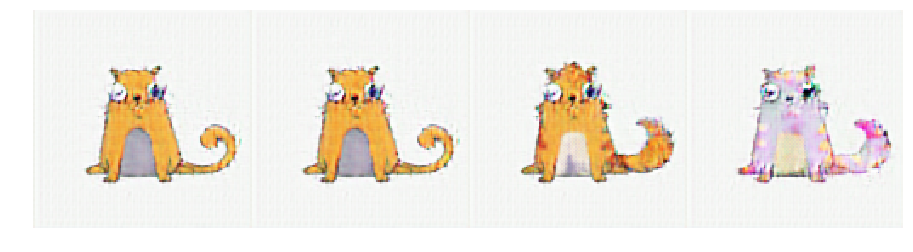

2511 0.81309774518013 0.5 0.28531962633132935 1.0
2512 0.6938530802726746 0.5 0.29973217844963074 0.96875
2513 0.6848816573619843 0.5 0.38280177116394043 0.96875
2514 0.6382564902305603 0.5625 0.42861366271972656 0.9375
2515 0.4681088775396347 0.75 0.6574665307998657 0.5
2516 0.5423617959022522 0.671875 0.5091221332550049 0.71875
2517 0.7559448182582855 0.515625 0.3422014117240906 0.9375
2518 0.5925330817699432 0.609375 0.5135629177093506 0.8125
2519 0.8053965270519257 0.546875 0.20544961094856262 1.0
2520 0.6300524175167084 0.578125 0.4302210211753845 0.8125


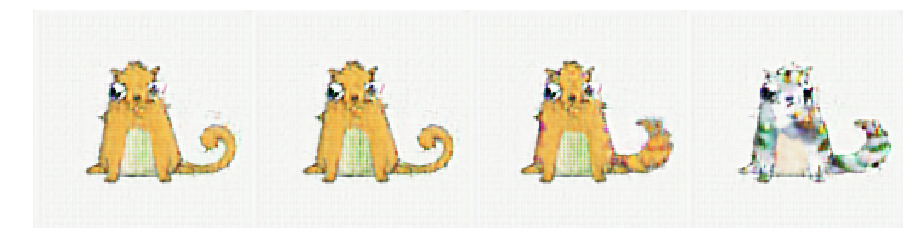

2521 0.7931750118732452 0.53125 0.2706995904445648 0.96875
2522 1.4627698063850403 0.5 0.08257462084293365 1.0
2523 0.9586155414581299 0.5 0.21604755520820618 1.0
2524 0.9971434473991394 0.5 0.22741709649562836 1.0
2525 0.9734020531177521 0.5 0.22117692232131958 1.0
2526 1.210867702960968 0.4375 0.13409438729286194 1.0
2527 1.4755241870880127 0.453125 0.08329620957374573 1.0
2528 1.0496732592582703 0.359375 0.27670562267303467 1.0
2529 1.3730590343475342 0.453125 0.1325639933347702 1.0
2530 0.9112997949123383 0.5 0.23842379450798035 1.0


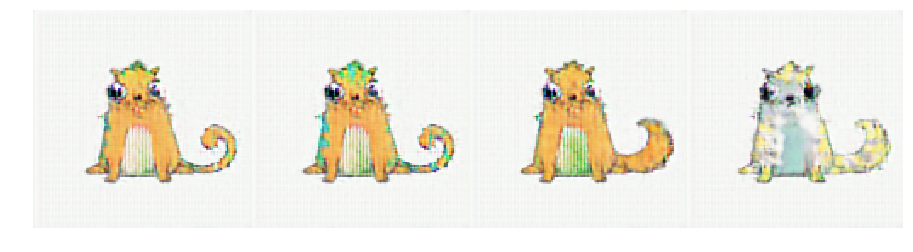

2531 0.9455559849739075 0.5 0.22675594687461853 1.0
2532 0.9905553758144379 0.484375 0.25412479043006897 1.0
2533 1.1483492255210876 0.5 0.15073442459106445 1.0
2534 1.5285472869873047 0.5 0.07576964795589447 1.0
2535 1.0170846581459045 0.5 0.1476835310459137 1.0
2536 1.6308907866477966 0.5 0.09188579767942429 1.0
2537 1.7769859433174133 0.484375 0.051076702773571014 1.0
2538 1.6476712226867676 0.5 0.05951967462897301 1.0
2539 1.559848427772522 0.5 0.06299632042646408 1.0
2540 1.6773202419281006 0.359375 0.06424196064472198 1.0


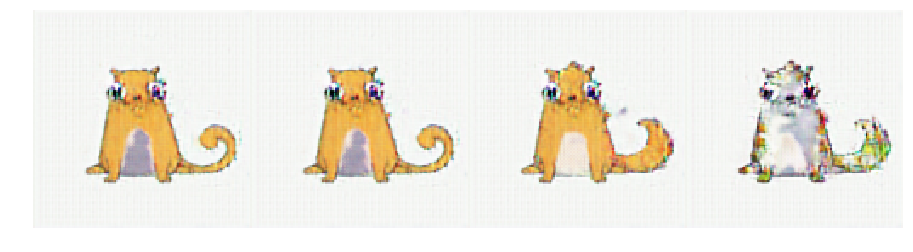

2541 1.9340015053749084 0.28125 0.04473555088043213 1.0
2542 1.7352378964424133 0.484375 0.04499605670571327 1.0
2543 1.650194525718689 0.5 0.051235079765319824 1.0
2544 1.2098385691642761 0.484375 0.13399042189121246 1.0
2545 0.8934390544891357 0.5 0.2723616361618042 1.0
2546 0.8432830572128296 0.578125 0.3166104555130005 0.875
2547 1.1267090439796448 0.4375 0.14782334864139557 1.0
2548 0.734222948551178 0.546875 0.4319482147693634 0.75
2549 0.7385081052780151 0.515625 0.326822429895401 0.9375
2550 0.7661173343658447 0.59375 0.4154362082481384 0.78125


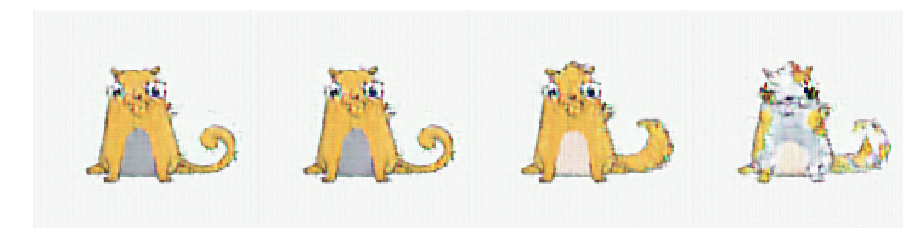

2551 0.7371999025344849 0.546875 0.4052019417285919 0.875
2552 0.7841478884220123 0.46875 0.48549795150756836 0.84375
2553 1.2590453028678894 0.4375 0.1547544300556183 1.0
2554 1.0142796635627747 0.484375 0.18181216716766357 1.0
2555 1.215975046157837 0.40625 0.2435571253299713 1.0
2556 1.0547674894332886 0.5 0.173526793718338 1.0
2557 1.154818832874298 0.359375 0.22108541429042816 1.0
2558 1.2304536700248718 0.28125 0.3060637414455414 0.90625
2559 0.9936429262161255 0.328125 0.3955560326576233 0.96875
2560 0.9580567479133606 0.421875 0.35252150893211365 0.96875


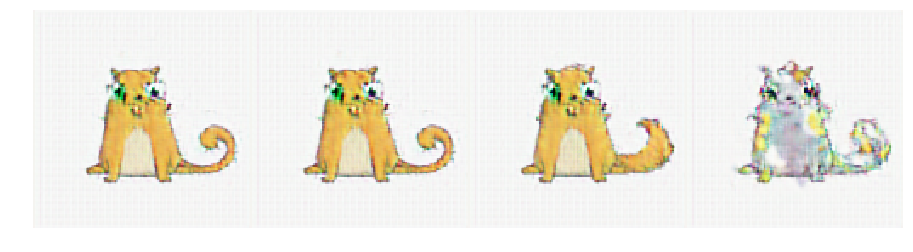

2561 0.8930505812168121 0.46875 0.26659083366394043 0.96875
2562 1.5283108949661255 0.484375 0.09298834204673767 1.0


KeyboardInterrupt: 

In [947]:
for i in range(2505,3000):
    
    X,Y = disc_batch(gen, batch_size=32, mode='random')
    dscore = disc.evaluate(X,Y,verbose=False)
    X,Y = gen_batch(batch_size=32)
    cscore = comb.evaluate(X,Y, verbose=False)
    scores.append([i]+dscore+cscore)
    print(*scores[-1])

    test = gen.predict(v)
    z = group_cats(test,4,4)
    imsave('cats/'+str(i)+'.png', z)
    
    if i%10==0:
        plt.figure(figsize=(16,4))
        plt.imshow(z[0:128,:,:])
        plt.axis('off')
        plt.show()
        
    
    for k in range(epoch_size):
        disc.trainable = True
        if np.random.rand() > .5:
            X,Y = disc_batch(gen, batch_size=16, mode='positive')
        else:
            X,Y = disc_batch(gen, batch_size=16, mode='negative')
        disc.train_on_batch(X,Y)
        
        disc.trainable = False
        X,Y = gen_batch(batch_size=24)
        comb.train_on_batch(X,Y)
    


In [919]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(gen, 'gen3')

In [920]:
tfjs.converters.save_keras_model(gen, 'genquant3', np.uint16)

In [921]:
with open('gen.json','w') as f:
    f.write(gen.to_json())
    gen.save_weights('gen.h5')

with open('disc.json','w') as f:
    f.write(disc.to_json())
    disc.save_weights('disc.h5')

print('saved!')

saved!


In [918]:
i

2505

In [922]:
import pandas as pd
df = pd.DataFrame(scores)
df.columns=['epoch','disc_loss','disc_acc','gen_loss','gen_acc']
df.to_csv('train_log.csv',index=None)
df.head()

,epoch,disc_loss,disc_acc,gen_loss,gen_acc
0,0,0.781227,0.500000,0.697345,0.00000
1,1,2.713490,0.140625,0.014936,1.00000
2,2,0.936675,0.468750,1.374748,0.15625
3,3,0.934039,0.234375,0.696894,0.59375
4,4,0.613329,0.609375,0.522823,0.71875


In [925]:
import seaborn as sns

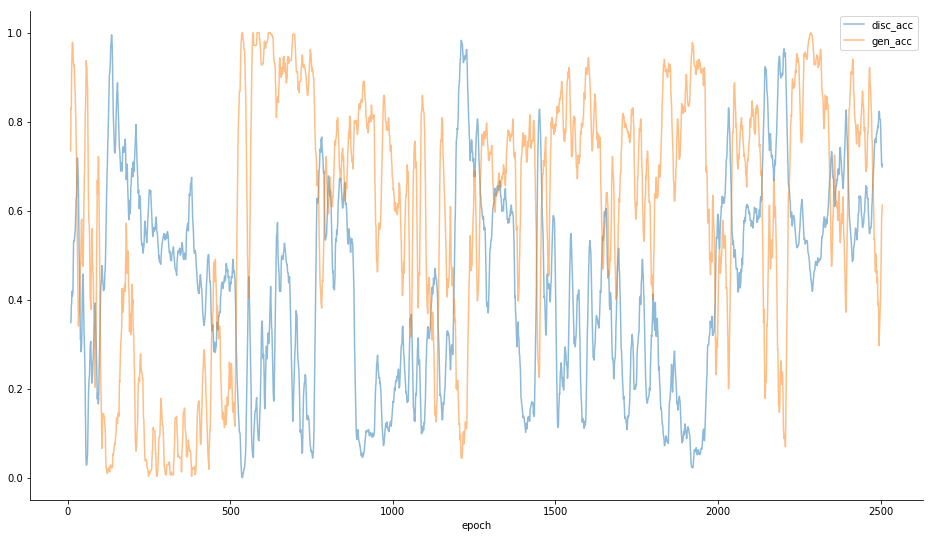

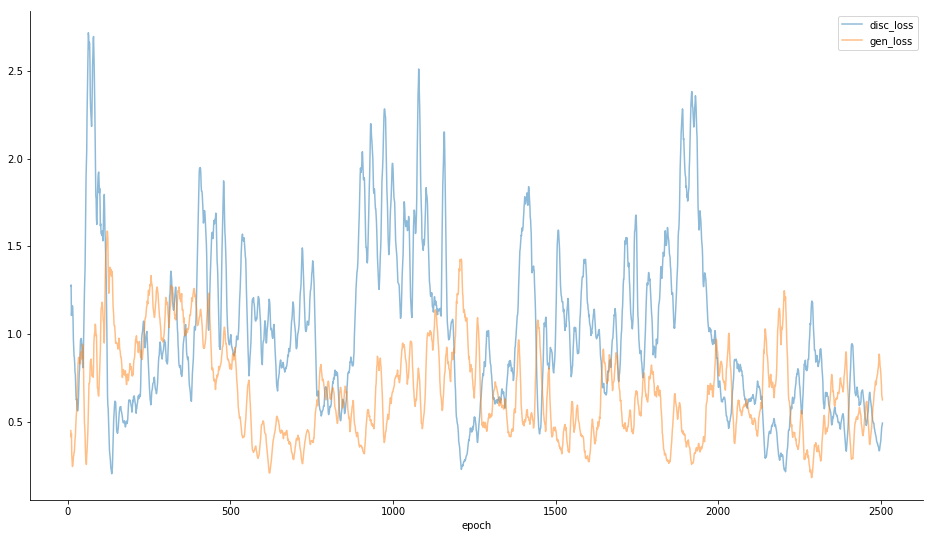

In [942]:
plt.figure(figsize=(16,9))
df.set_index('epoch')[['disc_acc','gen_acc']].rolling(10).mean().dropna().plot(alpha=.5, ax=plt.gca())
sns.despine()

plt.figure(figsize=(16,9))
df.set_index('epoch')[['disc_loss','gen_loss']].rolling(10).mean().dropna().plot(alpha=.5, ax=plt.gca())
sns.despine()